Initiating Segment Attributes...
Merging Segments...
20 segments merged
40 segments merged
51 segments merged - final


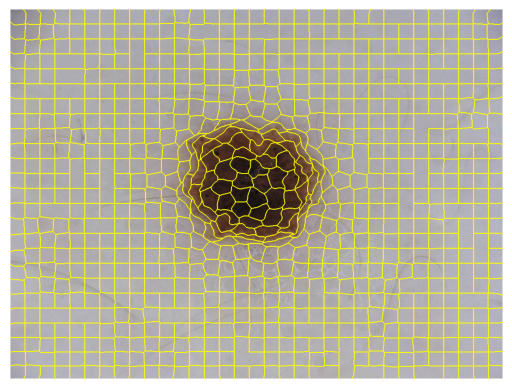

In [3]:
### Superpixel Hierarchical Clustering algorithm (SPHC)
## Method and Code for merging Superpixels created by Paul Thompson (Please credit if you use this code)
# The algorithm takes image superpixels created by the skimage SLIC function and merges neighors in order of
# color similarity (using euclidean distance).

#References:
#1. http://www.kev-smith.com/papers/SLIC_Superpixels.pdf
#2. http://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/

#####INSTRUCTIONS###################################################################################
### To use:
### 1. Change the parameters below
### 2. Change image path. This was only tested with jpg's.
### 3. Run program

imagePath = '/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/ISIC_0000001.png'

#SLIC Parameters:
numSegments = 800  # How many superpixels to start with - input for SLIC function
Sigma = 4 # This parameter controls superpixel shape. Higher values make superpixels more square.

#SPHC Parameters:
segmentsToMerge = 50 # How many superpixels to merge based on color similarity
distance_limit = .6  # Limits which segments get merged based on their difference in average color
####################################################################################################

import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
from skimage import io
from collections import defaultdict

def initiateSegmentAttributes(segm_grid, image):
    '''
    Each segment formed by sklearn's SLIC function is assigned a dictionary of attributes for efficiency.
    :param segm_grid: Each pixel has been identified with a segment identifier by the skimage SLIC function
    :param image: Each pixel has R, B, and G value associated with it
    :return: Dictionary of dictionaries of attributes for each segment
    '''
    def initialSegmAttr():
        return {'neighbors': set(), 'R': [], 'G': [], 'B': [], 'coord': set(),
                         'R_avg': 0.0, 'G_avg': 0.0, 'B_avg': 0.0}
    segm_dict = defaultdict(initialSegmAttr)

    for i in range(len(segm_grid)):
        for j in range(len(segm_grid[i])):
            if j != len(segm_grid[i]) - 1 and segm_grid[i][j] != segm_grid[i][j+1]:
                segm_dict[segm_grid[i][j]]['neighbors'].add(segm_grid[i][j+1])
                segm_dict[segm_grid[i][j+1]]['neighbors'].add(segm_grid[i][j])
            if i != len(segm_grid) - 1 and segm_grid[i][j] != segm_grid[i+1][j]:
                segm_dict[segm_grid[i][j]]['neighbors'].add(segm_grid[i+1][j])
                segm_dict[segm_grid[i+1][j]]['neighbors'].add(segm_grid[i][j])
            segm_dict[segm_grid[i][j]]['R'].append(image[i][j][0])
            segm_dict[segm_grid[i][j]]['B'].append(image[i][j][1])
            segm_dict[segm_grid[i][j]]['G'].append(image[i][j][2])
            segm_dict[segm_grid[i][j]]['coord'].add((i,j))
    return segm_dict

def getNearestNeighbors(segm_dict):
    '''
    Calculates the average R, B, and G values for each segment. Then finds the two neighboring segments with
    the smallest euclidean distance (for the three dimensions of R, B, and G).
    :param segm_dict: dictionary of dictionaries of segment attributes
    :return: segment pair with smallest color euclidean distance; distance value
    '''
    for k, v in segm_dict.items():
        v['R_avg'] = sum(v['R'])/len(v['R'])
        v['B_avg'] = sum(v['B'])/len(v['B'])
        v['G_avg'] = sum(v['R'])/len(v['G'])
    neighbor_pairs = set()
    nearest_neighbors = []
    shortest_dist = 100.0

    for k, v in segm_dict.items():
        for neighbor in v['neighbors']:
            neighbor_pair = tuple(sorted([k, neighbor]))
            if neighbor_pair not in neighbor_pairs and k != neighbor:
                neighbor_pairs.add(neighbor_pair)
                eucl_dist = float(math.sqrt((v['R_avg'] - segm_dict[neighbor]['R_avg']) ** 2 +
                                            (v['B_avg'] - segm_dict[neighbor]['B_avg']) ** 2 +
                                            (v['G_avg'] - segm_dict[neighbor]['G_avg']) ** 2))
                if eucl_dist < shortest_dist:
                    shortest_dist = eucl_dist
                    nearest_neighbors = neighbor_pair
    return nearest_neighbors, shortest_dist

def mergeSegments(segm_dict, nearest_neighbors):
    '''
    Merges the pair of neighboring segments with the shortest euclidean distance (greatest color similarity)
    :param segm_dict: dictionary of dictionaries of segment attributes
    :param nearest_neighbors: segment pair with smallest color euclidean distance
    :return: segm_dict: updated dictionary of dictionaries of segment attributes
    '''
    mergeto_dict = segm_dict[nearest_neighbors[0]]
    mergefrom_dict = copy.deepcopy(segm_dict[nearest_neighbors[1]])

    mergeto_dict['neighbors'] = mergeto_dict['neighbors'] | mergefrom_dict['neighbors']
    mergeto_dict['neighbors'].discard(nearest_neighbors[0])
    mergeto_dict['R'] += mergefrom_dict['R']
    mergeto_dict['B'] += mergefrom_dict['B']
    mergeto_dict['G'] += mergefrom_dict['G']
    mergeto_dict['coord'] = mergeto_dict['coord'] | mergefrom_dict['coord']

    for neighbor in mergefrom_dict['neighbors']:
        segm_dict[neighbor]['neighbors'].add(nearest_neighbors[0])
        segm_dict[neighbor]['neighbors'].discard(nearest_neighbors[1])

    del segm_dict[nearest_neighbors[1]]
    return segm_dict

def getSPHCsegments(segm_grid, image, numToMerge = 10, max_dist = 1.0):
    '''
    Main function for running SPHC clustering algorithm. Initiates segment attributes. Then
    iteratively finds and merges neighboring segments with most similar color.
    :param segm_grid: Each pixel has been identified with a segment identifier by the skimage SLIC function
    :param image: Each pixel has R, B, and G value associated with it
    :param numToMerge: User input - number of segments to merge. Must be less than number of segments.
    :param max_dist: Maximum euclidean distance for pair of segments to merge
    :return: segm_grid: Each pixel has been identified with a segment identifier by the SPHC function
    '''
    print ("Initiating Segment Attributes...")
    segm_dict = initiateSegmentAttributes(segm_grid, image)
    shortest_dist = 0.0
    merge_count = 0

    print ("Merging Segments...")
    while shortest_dist <= max_dist and merge_count <= numToMerge:
        nearest_neighbors, shortest_dist = getNearestNeighbors(segm_dict)
        segm_dict = mergeSegments(segm_dict, nearest_neighbors)
        merge_count += 1
        if merge_count % 20 == 0:
            print (merge_count, "segments merged")

    print (merge_count, "segments merged - final")

    newSegmGrid = copy.deepcopy(segm_grid)
    for k, v in segm_dict.items():
        for coord in v['coord']:
            newSegmGrid[coord[0], coord[1]] = int(k)

    return newSegmGrid


if __name__ == '__main__':
    image = img_as_float(io.imread(imagePath))
    SLICsegm_grid = slic(image, n_segments = numSegments, sigma = Sigma)

    SPHCsegm_grid = getSPHCsegments(SLICsegm_grid, image, numToMerge = segmentsToMerge, max_dist = distance_limit)

    fig = plt.figure("%d Segments Merged" % segmentsToMerge)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, SPHCsegm_grid))
    plt.axis("off")
    plt.show()
